In [132]:
import numpy as np
import pandas as pd
import xgboost as xgb
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [133]:
df = pd.read_csv('../udataset/hourly_earnings.csv')
meat_prod_df = pd.read_csv('../udataset/meat/production.csv')
# meat_cold_df = pd.read_csv('../udataset/meat/cold_storage.csv')
# meat_weights_df = pd.read_csv('../udataset/meat/weights.csv')
# meat_slaughter_df = pd.read_csv('../udataset/meat/slaughter.csv')


df = df.rename(columns={'YearMonth': 'date'})
meat_prod_df = meat_prod_df.rename(columns={'DateTime': 'date'})
# meat_cold_df = meat_cold_df.rename(columns={'DateTime': 'date'})
# meat_weights_df = meat_weights_df.rename(columns={'DateTime': 'date'})
# meat_slaughter_df = meat_slaughter_df.rename(columns={'DateTime': 'date'})



df['date'] = pd.to_datetime(df['date'])
meat_prod_df['date'] = pd.to_datetime(meat_prod_df['date'])
# meat_cold_df['date'] = pd.to_datetime(meat_cold_df['date'])
# meat_weights_df['date'] = pd.to_datetime(meat_weights_df['date'])
# meat_slaughter_df['date'] = pd.to_datetime(meat_slaughter_df['date'])

df = df.merge(meat_prod_df, on = ['date'], how='left')
# df = df.merge(meat_cold_df, on = ['date'], how='left')
# df = df.merge(meat_weights_df, on = ['date'], how='left')
# df = df.merge(meat_slaughter_df, on = ['date'], how='left')

for col in df.columns[2:]:
    df[col] = df[col].pct_change()

df = df.dropna()
# df = df.drop(columns=['State'])
df = df[df['date'].dt.year < 2020]

model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
print(df.columns)


Index(['State', 'date', 'HourlyEarnings', 'Beef', 'Veal', 'Pork',
       'Lamb and Mutton', 'Broiler', 'Other Chicken', 'Turkey', 'Red Meat',
       'Poultry'],
      dtype='object')


/var/folders/_z/09vrqlq533g4mwf_3hh2dzrc0000gn/T/ipykernel_62911/2038512874.py:28: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[col] = df[col].pct_change()


In [134]:
train_df = df[df['date'].dt.year < 2017]
test_df = df[df['date'].dt.year >= 2017]

tmp_train_df = train_df.drop(columns=['date', 'HourlyEarnings', 'State'])
tmp_test_df = test_df.drop(columns=['date', 'HourlyEarnings', 'State'])

# PCA - Feature selection #################
scaler = StandardScaler()
scaled_trained = scaler.fit_transform(tmp_train_df)
scaled_test = scaler.transform(tmp_test_df)


pca = PCA(n_components=7)
pca_train = pca.fit_transform(scaled_trained)
pca_test = pca.transform(scaled_test)
##########################################

n_components = 7
train_pca_df = pd.DataFrame(pca_train, columns=[f"PC{i}" for i in range(1, n_components + 1)])
test_pca_df = pd.DataFrame(pca_test, columns=[f"PC{i}" for i in range(1, n_components + 1)])

# train_pca_df = pd.DataFrame(pca_train, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# test_pca_df = pd.DataFrame(pca_test, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_pca_df = pd.concat([train_df[['date', 'HourlyEarnings', 'State']], train_pca_df], axis=1)
test_pca_df = pd.concat([test_df[['date', 'HourlyEarnings', 'State']], test_pca_df], axis=1)

print(train_pca_df)

train_labels = train_pca_df['HourlyEarnings'].to_numpy()
test_labels = test_pca_df['HourlyEarnings'].to_numpy()

train_pca_df = train_pca_df.drop(columns=['date', 'HourlyEarnings'])
test_pca_df = test_pca_df.drop(columns=['date', 'HourlyEarnings'])

# train_data = train_pca_df.to_numpy()
# train_labels = train_data[:, 2]

# test_data = test_pca_df.to_numpy()
# test_labels = test_data[:, 2]

train_data = train_pca_df.to_numpy()
test_data = test_pca_df.to_numpy()

# train_data = np.delete(train_data, 1, axis=1)
# test_data = np.delete(test_data, 1, axis=1)

print(train_data)
print(train_labels)
print(test_data.shape)

           date  HourlyEarnings    State       PC1       PC2       PC3  \
0    2007-02-01        0.002599  alabama -3.812926  0.122671  0.417212   
1    2007-03-01        0.005702  alabama  3.858519  0.964333  0.670638   
2    2007-04-01        0.006701  alabama -2.009211 -1.283790 -0.222055   
3    2007-05-01       -0.005632  alabama  2.993666 -0.491331  0.027436   
4    2007-06-01       -0.003605  alabama -1.282242 -0.639550  0.558336   
...         ...             ...      ...       ...       ...       ...   
6114 2016-08-01        0.004842  wyoming  4.528951 -0.485535 -0.023801   
6115 2016-09-01        0.018397  wyoming -1.762577 -0.013302  0.917902   
6116 2016-10-01        0.021935  wyoming  0.093399  0.251611 -0.820972   
6117 2016-11-01        0.000421  wyoming -0.036863  0.158878  0.609885   
6118 2016-12-01       -0.005048  wyoming -0.525380  0.374072 -0.110224   

           PC4       PC5       PC6       PC7  
0     0.270356  0.676598  0.019859 -0.590853  
1    -1.178153  0

In [135]:
le = LabelEncoder()
le.fit(train_data[:, 0])
train_data[:, 0] = le.transform(train_data[:, 0])
train_data.shape

(6119, 8)

In [136]:
# define model evaluation method
# evaluate model
# scores = cross_val_score(model, train_data, train_labels, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
model.fit(train_data, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [137]:
raw_test_labels = test_data[:, 0]
test_data[:, 0] = le.transform(test_data[:, 0])
test_data.shape

(1836, 8)

In [138]:
#scores = absolute(scores)
#print(scores)
#print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
preds = model.predict(test_data)

In [139]:
preds

array([ 0.01226886,  0.00273234, -0.00276077, ..., -0.00741373,
       -0.00730484,  0.00735303], dtype=float32)

In [140]:
(absolute(test_labels - preds)).mean()


0.007397100570230124

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583],
      dtype='int64', length=108)


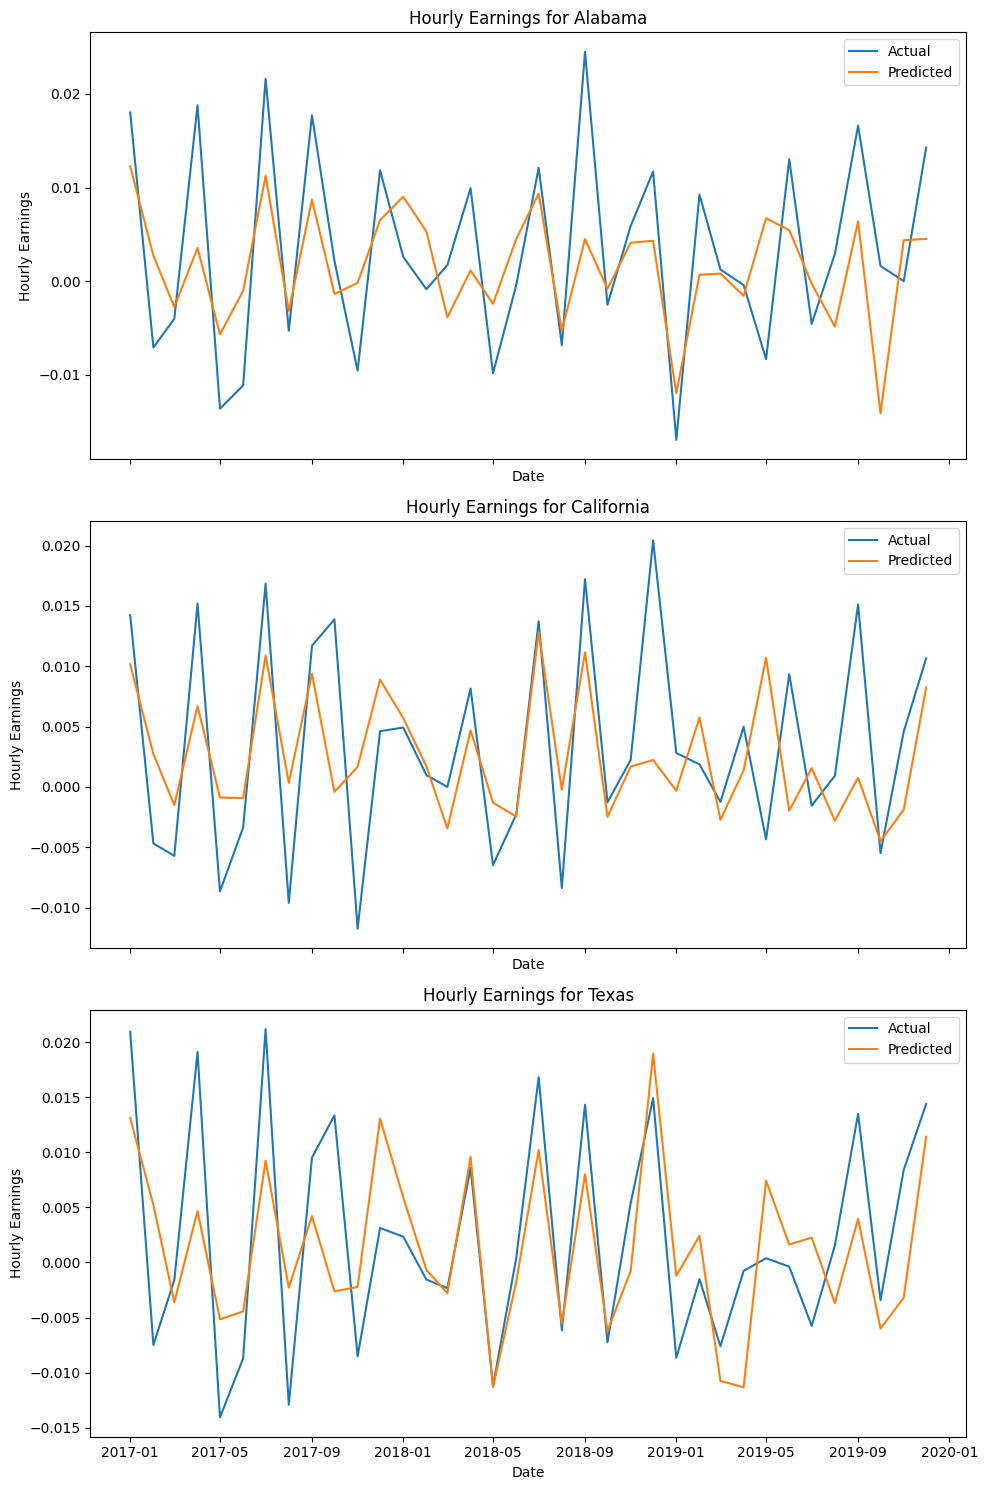

In [141]:

df_plot = df[df['date'].dt.year >= 2017]
df_plot = df_plot.reset_index(drop=True)
states_list = ['alabama', 'california', 'texas'] # CAN ADD ANY STATES YOU WANT

state_indexes = df_plot[df_plot['State'].str.lower().isin([state.lower() for state in states_list])].index
print(state_indexes)

plot_preds = []
plot_test_labels = []

fig, axs = plt.subplots(len(states_list), figsize=(10, 5 * len(states_list)), sharex=True)


for i, state in enumerate(states_list):

    state_indexes = df_plot[df_plot['State'].str.lower() == state.lower()].index

    plot_preds = preds[state_indexes]
    plot_test_labels = test_labels[state_indexes]

    axs[i].plot(df_plot['date'].iloc[state_indexes], plot_test_labels, label='Actual')
    axs[i].plot(df_plot['date'].iloc[state_indexes], plot_preds, label='Predicted')

    axs[i].set_title(f'Hourly Earnings for {state.title()}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Hourly Earnings')
    axs[i].legend()

plt.tight_layout()
plt.show()

